In [1]:
%load_ext autoreload
%autoreload 1
%aimport pygenesig.pybioqc
%aimport pygenesig.tools
%aimport pygenesig.file_formats
%matplotlib inline


from pygenesig.pybioqc import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
from pygenesig.file_formats import * 
from scipy.stats import mannwhitneyu
import pandas as pd
from pylab import * 
import seaborn as sns

In [2]:
exprs = read_expr("../pygenesig-example/data_processed/v6/exprs.npy")
target = read_target("../pygenesig-example/data_processed/v6/target.csv")
rosetta = read_rosetta("../pygenesig-example/data_processed/v6/rosetta.csv", inverse=True)

In [3]:
signatures = load_gmt("../pygenesig-example/results/gtex_v6_solid_gini_0.8_1/signatures.gmt")
signatures_ind = translate_signatures(signatures, rosetta, ignore_missing=True)
signatures_ind = {
    tissue: np.array(inds) for tissue, inds in signatures_ind.items()
}

In [4]:
target

array(['Adipose_Subcutaneous', 'Adipose_Subcutaneous',
       'Adipose_Subcutaneous', ..., 'Whole_Blood', 'Whole_Blood',
       'Whole_Blood'], 
      dtype='<U37')

In [5]:
target_name = {
    'tissue1': 'Pancreas',
    'tissue2': 'Liver'
}

In [6]:
sig_name = {
    'tissue1': 'Pancreas',
    'tissue2': 'Liver'
}

In [7]:
np.where(target == target_name['tissue1'])

(array([6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126,
        6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137,
        6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148,
        6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159,
        6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170,
        6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181,
        6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192,
        6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203,
        6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214,
        6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225,
        6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236,
        6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247,
        6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258,
        6259, 6260, 6261, 6262, 6263, 

In [8]:
np.where(target == target_name['tissue2'])

(array([4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799,
        4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810,
        4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821,
        4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832,
        4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843,
        4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854,
        4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865,
        4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876,
        4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887,
        4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898,
        4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907]),)

In [9]:
s_ind = {
    'tissue1': np.flatnonzero(target == target_name['tissue1'])[0],
    'tissue2': np.flatnonzero(target == target_name['tissue2'])[0]
}
s_ind

{'tissue1': 6116, 'tissue2': 4789}

In [10]:
s = {
    tissue: exprs[:, i] for tissue, i in s_ind.items()
}

In [11]:
ind = {
    tissue: np.array([True if i in signatures_ind[name] else False for i in range(exprs.shape[0])])
    for tissue, name in sig_name.items()
}

In [12]:
rel_rk = {
    tissue: pd.DataFrame(exprs[:, target == target_name[tissue]]).rank(
        axis=0, ascending=False).iloc[ind[tissue], :].median(axis=0).median() / exprs.shape[0] for tissue in s
}
rel_rk

{'tissue1': 0.022416057024948415, 'tissue2': 0.02013380854123679}

In [13]:
size = {
    tissue: sum(t_ind) for tissue, t_ind in ind.items()
}
size

{'tissue1': 147, 'tissue2': 322}

In [14]:
overlap = jaccard_ind(*(signatures_ind[sig_name[tissue]] for tissue in s))
overlap

0.078160919540229884

In [15]:
def mix(x, y, prop_x):
    return x * prop_x + y * (1 - prop_x)

In [16]:
def wmw_r_corr(x, y, u, u_exp):
    return 1 - (2 * (u - u_exp)) / (x.size * y.size)

In [17]:
mixed = [mix(s['tissue1'], s['tissue2'], f) for f in np.arange(0, 1.01, 0.01)]

In [18]:
wmw_res = {
    tissue:  [mannwhitneyu(s_mixed[~ind[tissue]], s_mixed[ind[tissue]]) for s_mixed in mixed] for 
    tissue in ind
}
wmw_res

{'tissue1': [MannwhitneyuResult(statistic=1518243.5, pvalue=1.1379824203371115e-14),
  MannwhitneyuResult(statistic=978753.0, pvalue=4.0553368090382053e-36),
  MannwhitneyuResult(statistic=879391.0, pvalue=2.8174400551345451e-41),
  MannwhitneyuResult(statistic=817355.0, pvalue=1.1150465386323861e-44),
  MannwhitneyuResult(statistic=771567.0, pvalue=2.7930207060521102e-47),
  MannwhitneyuResult(statistic=734389.0, pvalue=1.8960507298330332e-49),
  MannwhitneyuResult(statistic=703648.0, pvalue=2.7991292218045777e-51),
  MannwhitneyuResult(statistic=676822.0, pvalue=6.6258540224580874e-53),
  MannwhitneyuResult(statistic=653138.0, pvalue=2.3125776335551593e-54),
  MannwhitneyuResult(statistic=632024.0, pvalue=1.1164579759177109e-55),
  MannwhitneyuResult(statistic=613030.0, pvalue=7.0774094972641499e-57),
  MannwhitneyuResult(statistic=595649.0, pvalue=5.52233913137952e-58),
  MannwhitneyuResult(statistic=579785.0, pvalue=5.2656001817604146e-59),
  MannwhitneyuResult(statistic=565132.0, 

In [19]:
wmw_exp = {}
for tissue in ind:
    y = np.repeat(np.percentile(s[tissue], (1- rel_rk[tissue]) * 100), size[tissue])
    u, p = mannwhitneyu(s[tissue], y)
    wmw_exp[tissue] = (wmw_r(s[tissue], y, u), u, p) 
wmw_exp

{'tissue1': (0.95516788595010316, 105399.0, 6.1961914241669692e-96),
 'tissue2': (0.95973238291752638, 207368.0, 5.1613217824207884e-208)}

In [20]:
u_exp = {
    tissue: wmw_u_exp(rel_rk[tissue], size[tissue], s[tissue].size) for tissue in ind
}
u_exp

{'tissue1': 94521.0, 'tissue2': 155365.0}

## BioQC score, corrected and uncorrected

In [21]:
wmw_score_corr = {
    tissue: [-np.log10(p) / -np.log10(wmw_exp[tissue][2]) for u, p in res] for tissue, res in wmw_res.items()
}
wmw_score = {
    tissue: [-np.log10(p) for u, p in res] for tissue, res in wmw_res.items()
}

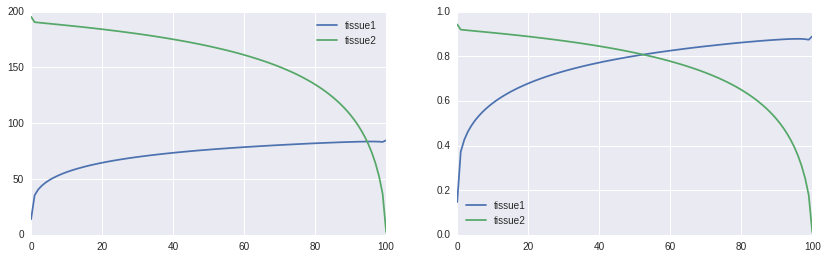

In [22]:
fix, (ax1, ax2) = subplots(1, 2, figsize=(14, 4))
pd.DataFrame(wmw_score).plot(ax=ax1)
pd.DataFrame(wmw_score_corr).plot(ax=ax2)

## $r$ effect size, corrected and uncorrected

In [23]:
r = {
    tissue: [wmw_r(s_mixed[~ind[tissue]], s_mixed[ind[tissue]], u) for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}
r_corr = {
    tissue: [wmw_r(s_mixed[~ind[tissue]], s_mixed[ind[tissue]], u) / wmw_exp[tissue][0] for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}
r_corr_u = {
    tissue: [wmw_r_corr(s_mixed[~ind[tissue]], s_mixed[ind[tissue]], u, u_exp[tissue]) for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}

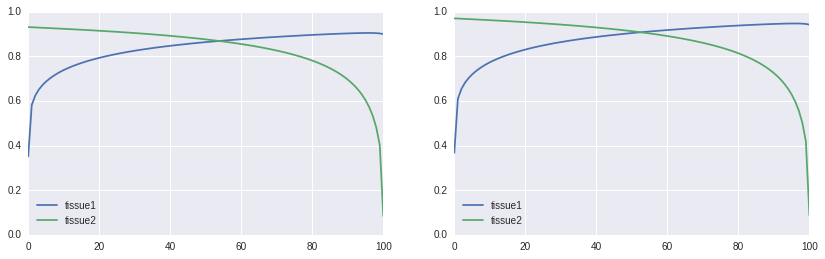

In [24]:
fix, (ax1, ax2) = subplots(1, 2, figsize=(14, 4))
pd.DataFrame(r).plot(ax=ax1)
pd.DataFrame(r_corr).plot(ax=ax2)

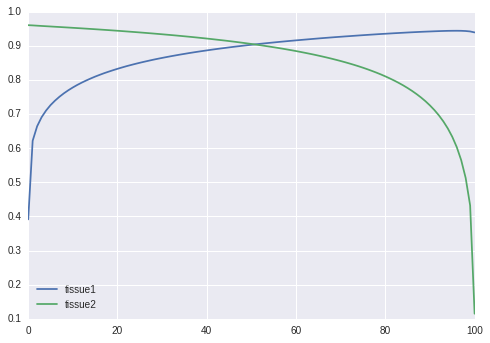

In [25]:
pd.DataFrame(r_corr_u).plot()

In [127]:
d = stats.gaussian_kde([x for x in mixed[-1] if 0 <= x <= 70])

In [128]:
xs = np.linspace(0, 20, 500)

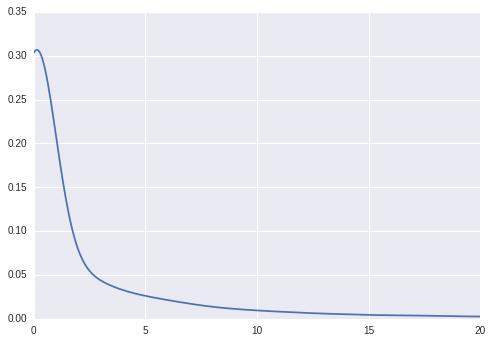

In [129]:
plot(xs, d(xs))

In [130]:
densities = {
    tissue: [d(np.median(mixed_s[ind[tissue]]))[0] for mixed_s in mixed] for tissue in s
}

In [131]:
r_density = {
    tissue: [r / d for r, d in zip(r_corr_u[tissue], densities[tissue])] for tissue in s
}

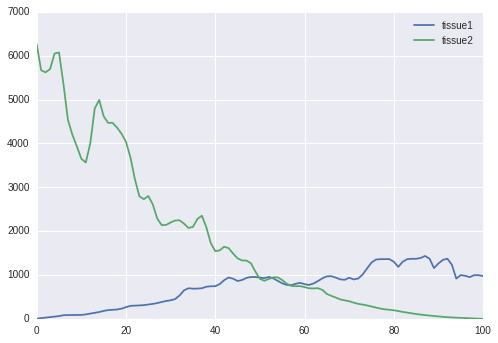

In [132]:
pd.DataFrame(r_density).plot()